## 1. Loading data

### 1.1. Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
import torch
import torch.nn as nn
import seaborn as sns
import math
import calendar
from sklearn.metrics import mean_squared_error
#import pytorch_lightning as pl
import warnings
warnings.filterwarnings("ignore")

## 2. Preparing data for analysis

### 2.1. Data preprocessing

In [2]:
df = pd.read_excel('data/raw_data.xlsx', skiprows=0)

In [3]:

del df['Unnamed: 0']
del df['CO2 PLN']
df = df.rename(columns={"Krajowe zapotrzebowanie na moc": "domestic electricity demand"})
df = df.rename(columns={"Generacja zrodel wiatrowych": "generation of energy from wind sources"})
df = df.rename(columns={"fixing I course (PLN/MWh)": "value"})

In [4]:
df

,date,value,domestic electricity demand,generation of energy from wind sources
0,2017-06-01 00:00:00,128.25,NaN,NaN
1,2017-06-01 01:00:00,111.26,NaN,NaN
2,2017-06-01 02:00:00,107.32,NaN,NaN
3,2017-06-01 03:00:00,106.87,NaN,NaN
4,2017-06-01 04:00:00,104.56,NaN,NaN
...,...,...,...,...
31339,2020-12-27 19:00:00,198.81,18254.0,5645.0
31340,2020-12-27 20:00:00,195.00,18242.0,5669.0
31341,2020-12-27 21:00:00,186.03,18021.0,5518.0
31342,2020-12-27 22:00:00,174.75,17370.0,5625.0


In [5]:
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
df['date_normalize'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d') 

def polish_label_weekday(row):
    
    if row['day_of_week'] == 0:
        return 'Poniedziałek'
    if row['day_of_week'] == 1:
        return 'Wtorek'
    if row['day_of_week'] == 2:
        return 'Środa'
    if row['day_of_week'] == 3:
        return 'Czwartek'
    if row['day_of_week'] == 4:
        return 'Piątek'
    if row['day_of_week'] == 5:
        return 'Sobota'
    if row['day_of_week'] == 6:
        return 'Niedziela'

df['pl_weekday'] = df.apply(lambda row: polish_label_weekday(row), axis=1)


def is_weekend(row):
    #if row['pl_weekday'] == 'Sobota' or row['pl_weekday'] == 'Niedziela':
    if row['pl_weekday'] == 'Niedziela':
        return 1
    else:
        return 0
df['is_weekend'] = df.apply(lambda row: is_weekend(row), axis=1)


def polish_label_holidays(row):
    
    if row['is_weekend'] == 0 and (row['date_normalize']=='2018-01-01' or row['date_normalize']=='2018-01-06'
    or row['date_normalize']=='2018-04-01' or row['date_normalize']=='2018-04-02' or row['date_normalize']=='2018-05-01' 
    or row['date_normalize']=='2018-05-03' or row['date_normalize']=='2018-05-31' or row['date_normalize']=='2018-08-15' 
    or row['date_normalize']=='2018-11-01' or row['date_normalize']=='2018-11-11' or row['date_normalize']=='2018-12-25' 
    or row['date_normalize']=='2018-12-26' or row['date_normalize']=='2019-01-01' or row['date_normalize']=='2019-01-06'
    or row['date_normalize']=='2019-04-21' or row['date_normalize']=='2019-04-22' or row['date_normalize']=='2019-05-01'
    or row['date_normalize']=='2019-05-03' or row['date_normalize']=='2019-06-09' or row['date_normalize']=='2019-06-20'
    or row['date_normalize']=='2019-08-15' or row['date_normalize']=='2019-11-01' or row['date_normalize']=='2019-11-11'
    or row['date_normalize']=='2019-12-25' or row['date_normalize']=='2019-12-26' or row['date_normalize']=='2020-01-01'
    or row['date_normalize']=='2020-01-06' or row['date_normalize']=='2020-04-12' or row['date_normalize']=='2020-04-13'
    or row['date_normalize']=='2020-05-01' or row['date_normalize']=='2020-05-03' or row['date_normalize']=='2020-06-11'
    or row['date_normalize']=='2020-08-15' or row['date_normalize']=='2020-11-11' or row['date_normalize']=='2020-12-25'
    or row['date_normalize']=='2020-12-26'):
        return 1
    
    if row['is_weekend'] == 1:
        return 1
    else:
        return 0
   
    
df['is_weekend'] = df.apply(lambda row: polish_label_holidays(row), axis=1)



df['hour'] = df.date.dt.hour

def label_hour(row):
    
    if row['hour'] >= 6 and row['hour'] <= 22:
        return 1
    
    else:
        return 0
   
    
df['code of the day'] = df.apply(lambda row: label_hour(row), axis=1)

del df['hour']
del df['pl_weekday']
del df['date_normalize']
del df['day_of_week']

In [6]:
df

,date,value,domestic electricity demand,generation of energy from wind sources,is_weekend,code of the day
0,2017-06-01 00:00:00,128.25,NaN,NaN,0,0
1,2017-06-01 01:00:00,111.26,NaN,NaN,0,0
2,2017-06-01 02:00:00,107.32,NaN,NaN,0,0
3,2017-06-01 03:00:00,106.87,NaN,NaN,0,0
4,2017-06-01 04:00:00,104.56,NaN,NaN,0,0
...,...,...,...,...,...,...
31339,2020-12-27 19:00:00,198.81,18254.0,5645.0,1,1
31340,2020-12-27 20:00:00,195.00,18242.0,5669.0,1,1
31341,2020-12-27 21:00:00,186.03,18021.0,5518.0,1,1
31342,2020-12-27 22:00:00,174.75,17370.0,5625.0,1,1


### 2.2. Generate lags

In [7]:
input_dim = 336


def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"value lag{n}"] = df_n["value"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
    
        
def generation_domestic_electricity_demand_lags(df, n_lags):

    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"domestic electricity demand lag{n}"] = df_n["domestic electricity demand"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
    
    

def generation_of_energy_from_wind_sources_lags(df, n_lags):

    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"generation of energy from wind sources lag{n}"] = df_n["generation of energy from wind sources"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
 
df = generate_time_lags(df, input_dim)
df = generation_of_energy_from_wind_sources_lags(df, input_dim)
df = generation_domestic_electricity_demand_lags(df, input_dim)

for n in range(1,337):
    if n == 24 or n== 48 or n== 72 or n== 96 or n== 120 or n== 144 or n== 168 or n== 336:
        continue
    else:
        del df[f'value lag{n}']
        del df[f'generation of energy from wind sources lag{n}']
        del df[f'domestic electricity demand lag{n}']
        

In [8]:
df = df[df['date']>='2018-01-01 01:00:00']

In [9]:
df

,date,value,domestic electricity demand,generation of energy from wind sources,is_weekend,code of the day,value lag24,value lag48,value lag72,value lag96,...,generation of energy from wind sources lag168,generation of energy from wind sources lag336,domestic electricity demand lag24,domestic electricity demand lag48,domestic electricity demand lag72,domestic electricity demand lag96,domestic electricity demand lag120,domestic electricity demand lag144,domestic electricity demand lag168,domestic electricity demand lag336
5137,2018-01-01 01:00:00,117.00,14586.0,3938.0,1,0,98.00,121.03,121.22,125.60,...,5042.0,130.0,15048.0,15984.0,16093.0,16198.0,14063.0,13451.0,13482.0,16716.0
5138,2018-01-01 02:00:00,113.59,14453.0,3876.0,1,0,82.00,121.03,120.00,120.42,...,5091.0,128.0,14295.0,15325.0,15383.0,15378.0,13525.0,12903.0,12995.0,16189.0
5139,2018-01-01 03:00:00,97.00,13692.0,3897.0,1,0,76.14,121.03,119.60,116.30,...,4999.0,119.0,14110.0,14971.0,15229.0,15136.0,13204.0,12755.0,12587.0,16108.0
5140,2018-01-01 04:00:00,89.00,13329.0,4091.0,1,0,74.70,121.03,119.60,116.30,...,4884.0,116.0,13961.0,14920.0,15160.0,15055.0,13243.0,12638.0,12276.0,16250.0
5141,2018-01-01 05:00:00,75.00,13168.0,4197.0,1,0,73.78,121.03,121.22,119.20,...,4673.0,110.0,13910.0,15013.0,15372.0,15158.0,13319.0,12787.0,12228.0,16819.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31339,2020-12-27 19:00:00,198.81,18254.0,5645.0,1,1,204.91,238.56,180.00,330.20,...,2653.0,197.0,17184.0,16568.0,16697.0,24065.0,24401.0,24650.0,20594.0,20903.0
31340,2020-12-27 20:00:00,195.00,18242.0,5669.0,1,1,212.91,226.30,155.10,314.38,...,2611.0,235.0,17339.0,16608.0,16535.0,23724.0,24123.0,24361.0,20472.0,20810.0
31341,2020-12-27 21:00:00,186.03,18021.0,5518.0,1,1,212.91,220.44,130.00,248.57,...,2435.0,250.0,17077.0,16381.0,16286.0,23029.0,23324.0,23697.0,20087.0,20090.0
31342,2020-12-27 22:00:00,174.75,17370.0,5625.0,1,1,207.89,214.67,122.77,229.32,...,2266.0,252.0,16479.0,16050.0,16124.0,21560.0,21806.0,22177.0,19237.0,19173.0


In [11]:
rows_with_nan = [index for index, row in df.iterrows() if row.isnull().any()]

In [12]:
rows_with_nan

[]

In [17]:
df2019 = df[df['date']<'2020-01-01 00:00:00'].reset_index(drop=True)
df2020 = df[df['date']>='2020-01-01 00:00:00'].reset_index(drop=True)


In [18]:
df2019

,date,fixing I course (PLN/MWh),month,month_name,hour,week,date_normalize,day_of_week,day_of_month,md,season,pl_weekday,pl_month_name,pl_season_name,quarter
0,2019-01-02 01:00:00,40.00,1.0,January,1.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
1,2019-01-02 02:00:00,31.00,1.0,January,2.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
2,2019-01-02 03:00:00,31.00,1.0,January,3.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
3,2019-01-02 04:00:00,31.00,1.0,January,4.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
4,2019-01-02 05:00:00,31.00,1.0,January,5.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8729,2019-12-31 19:00:00,185.00,12.0,December,19.0,1.0,2019-12-31,1.0,31.0,12-31,Winter,Wtorek,Grudzień,Zima,4
8730,2019-12-31 20:00:00,172.28,12.0,December,20.0,1.0,2019-12-31,1.0,31.0,12-31,Winter,Wtorek,Grudzień,Zima,4
8731,2019-12-31 21:00:00,157.63,12.0,December,21.0,1.0,2019-12-31,1.0,31.0,12-31,Winter,Wtorek,Grudzień,Zima,4
8732,2019-12-31 22:00:00,149.99,12.0,December,22.0,1.0,2019-12-31,1.0,31.0,12-31,Winter,Wtorek,Grudzień,Zima,4


In [ ]:
fig = plt.subplots(figsize=(12,7))

plt.plot(df['date'], df['fixing I course (PLN/MWh)'], label = 'line 1',
        linewidth=2.0)

# plt.fill_between(df2019_daily['date_normalize'], df2019_daily['fixing I course (PLN/MWh)'], alpha=0.2)
plt.title('Cena energii elektrycznej w latach',fontsize=12)
my_xticks = np.array(df['date_normalize'])
# frequency = 30
# plt.xticks(my_xticks[::frequency], my_xticks[::frequency], rotation=60)
plt.ylabel("Cena I fixingu (PLN/MwWh)")
plt.margins(0.02)
plt.ylim(120,270, 30)
plt.yticks(np.arange(0, 650, 50))

plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
#plt.grid()



plt.show()

### 2.3. Checking outliers 

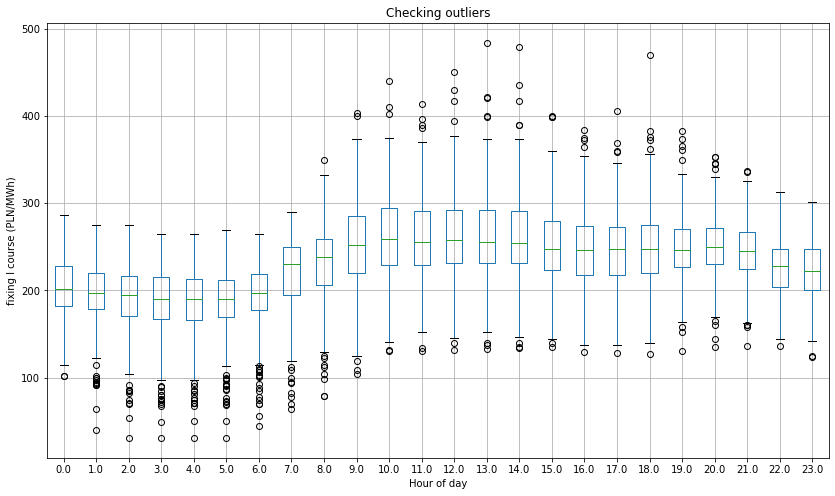

In [22]:
# box-plot to check outliers in individual hours for 2019
outpoints_hourly_2019 = df2019.pivot_table(index='date_normalize', 
                     columns=df2019['hour'], 
                     values='fixing I course (PLN/MWh)', 
                     aggfunc='mean').boxplot(figsize=(14,8)).set(title = "Checking outliers", xlabel = "Hour of day", ylabel = "fixing I course (PLN/MWh)")

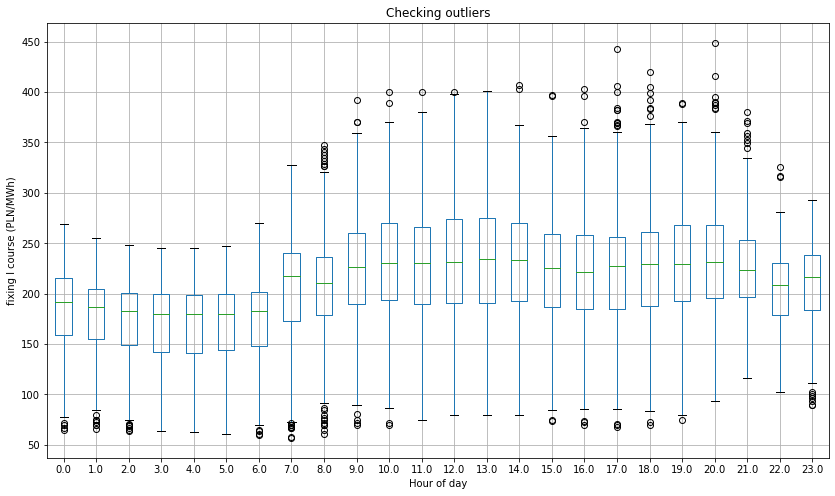

In [23]:
# box-plot to check outliers in individual hours for 2020
outpoints_hourly_2020 = df2020.pivot_table(index='date_normalize', 
                     columns=df2020['hour'], 
                     values='fixing I course (PLN/MWh)', 
                     aggfunc='mean').boxplot(figsize=(14,8)).set(title = "Checking outliers", xlabel = "Hour of day", ylabel = "fixing I course (PLN/MWh)")

In [25]:
df2019

,date,fixing I course (PLN/MWh),month,month_name,hour,week,date_normalize,day_of_week,day_of_month,md,season,pl_weekday,pl_month_name,pl_season_name,quarter
0,2019-01-02 01:00:00,40.00,1.0,January,1.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
1,2019-01-02 02:00:00,31.00,1.0,January,2.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
2,2019-01-02 03:00:00,31.00,1.0,January,3.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
3,2019-01-02 04:00:00,31.00,1.0,January,4.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
4,2019-01-02 05:00:00,31.00,1.0,January,5.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8729,2019-12-31 19:00:00,185.00,12.0,December,19.0,1.0,2019-12-31,1.0,31.0,12-31,Winter,Wtorek,Grudzień,Zima,4
8730,2019-12-31 20:00:00,172.28,12.0,December,20.0,1.0,2019-12-31,1.0,31.0,12-31,Winter,Wtorek,Grudzień,Zima,4
8731,2019-12-31 21:00:00,157.63,12.0,December,21.0,1.0,2019-12-31,1.0,31.0,12-31,Winter,Wtorek,Grudzień,Zima,4
8732,2019-12-31 22:00:00,149.99,12.0,December,22.0,1.0,2019-12-31,1.0,31.0,12-31,Winter,Wtorek,Grudzień,Zima,4


In [26]:
df_40 = df2019[df2019['week'] ==32].reset_index(drop=True)

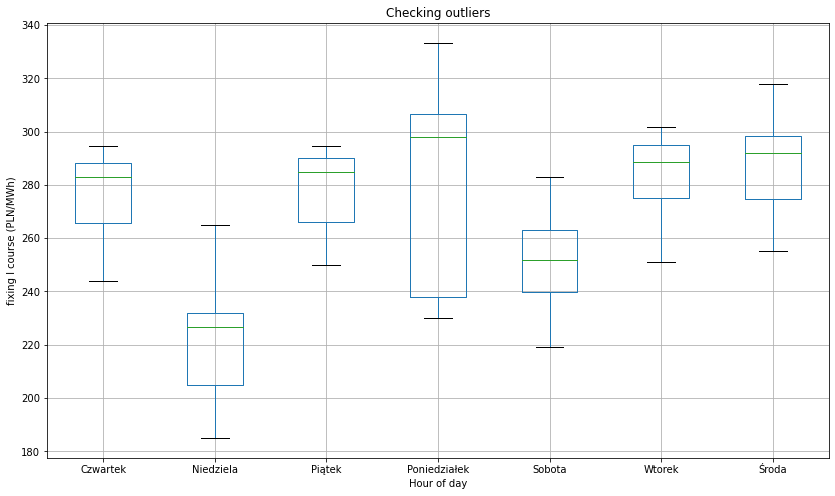

In [27]:
# box-plot to check outliers in individual hours for 2020
outpoints_hourly_2020 = df_40.pivot_table(index='date', 
                     columns=df_40['pl_weekday'], 
                     values='fixing I course (PLN/MWh)', 
                     aggfunc='mean').boxplot(figsize=(14,8)).set(title = "Checking outliers", xlabel = "Hour of day", ylabel = "fixing I course (PLN/MWh)")

In [ ]:
df.to_excel("data\data.xlsx") 

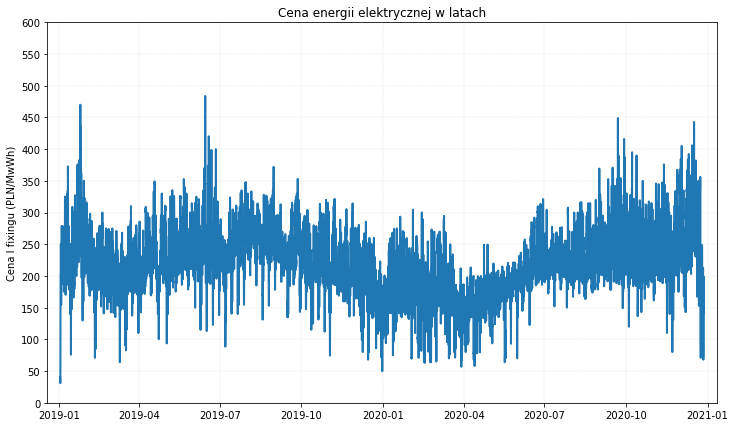

In [28]:
fig = plt.subplots(figsize=(12,7))

plt.plot(df['date'], df['fixing I course (PLN/MWh)'], label = 'line 1',
        linewidth=2.0)

# plt.fill_between(df2019_daily['date_normalize'], df2019_daily['fixing I course (PLN/MWh)'], alpha=0.2)
plt.title('Cena energii elektrycznej w latach',fontsize=12)
my_xticks = np.array(df['date_normalize'])
# frequency = 30
# plt.xticks(my_xticks[::frequency], my_xticks[::frequency], rotation=60)
plt.ylabel("Cena I fixingu (PLN/MwWh)")
plt.margins(0.02)
plt.ylim(120,270, 30)
plt.yticks(np.arange(0, 650, 50))

#plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
#plt.grid()



plt.show()

In [29]:
import statsmodels.api as sm

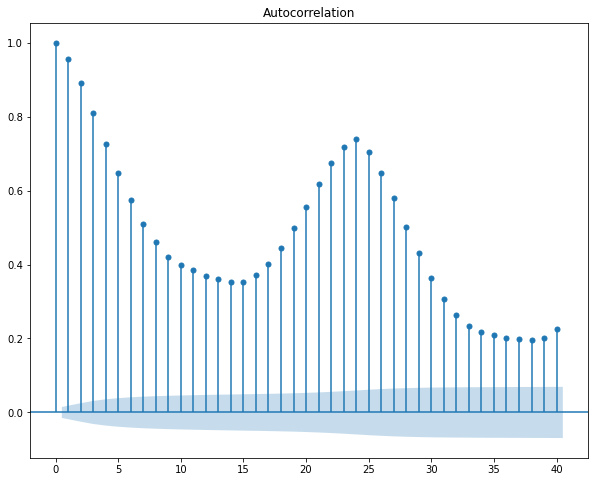

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.collections import PolyCollection

#sample data from their website


curr_fig, curr_ax = plt.subplots(figsize=(10, 8))

#change the color of the vlines
sm.graphics.tsa.plot_acf(df['fixing I course (PLN/MWh)'].squeeze(), lags=40, ax=curr_ax)
#get polygon patch collections and change their color


plt.show()

In [31]:
df['fixing I course (PLN/MWh)']

0         40.00
1         31.00
2         31.00
3         31.00
4         31.00
          ...  
17418    198.81
17419    195.00
17420    186.03
17421    174.75
17422    142.73
Name: fixing I course (PLN/MWh), Length: 17421, dtype: float64

In [32]:
from statsmodels.tsa.arima_process import ArmaProcess

In [33]:
import statsmodels.api as sm

In [34]:
def tsdisplay(y, figsize = (10, 8), title = "", lags = 20):
    tmp_data = pd.Series(y)
    fig = plt.figure(figsize = figsize)
    #Plot the time series
    _ = tmp_data.plot(ax = fig.add_subplot(311), title = "$Time\ Series\ " + title + "$", legend = False)
    #Plot the ACF:
    _ = sm.graphics.tsa.plot_acf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(323))
    _ = plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the PACF:
    _ = sm.graphics.tsa.plot_pacf(tmp_data, lags = 20, zero = False, ax = fig.add_subplot(324))
    _ = plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the QQ plot of the data:
    _ = sm.qqplot(tmp_data, line='s', ax = fig.add_subplot(325)) 
    _ = plt.title("QQ Plot")
    #Plot the residual histogram:
    _ = fig.add_subplot(326).hist(tmp_data, bins = 40, density = 1)
    _ = plt.title("Histogram")
    #Fix the layout of the plots:
    _ = plt.tight_layout()
    plt.show()

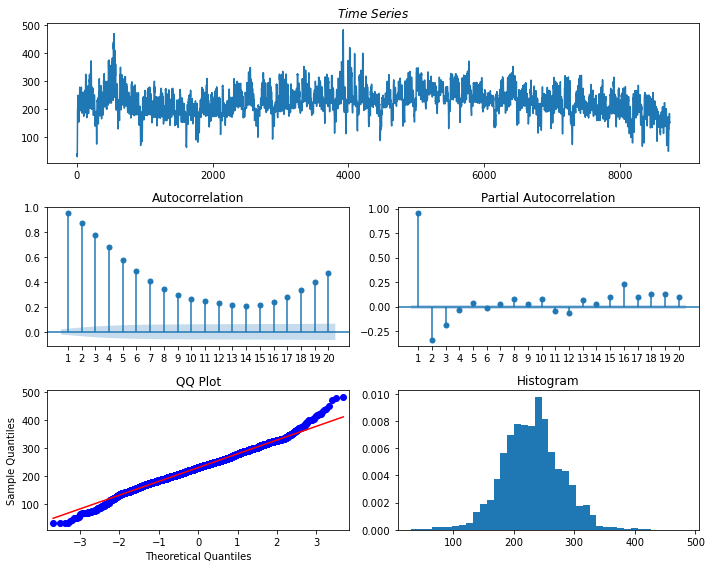

In [35]:
tsdisplay(df2019['fixing I course (PLN/MWh)'])

In [36]:
df

,date,fixing I course (PLN/MWh),month,month_name,hour,week,date_normalize,day_of_week,day_of_month,md,season,pl_weekday,pl_month_name,pl_season_name,quarter
0,2019-01-02 01:00:00,40.00,1.0,January,1.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
1,2019-01-02 02:00:00,31.00,1.0,January,2.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
2,2019-01-02 03:00:00,31.00,1.0,January,3.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
3,2019-01-02 04:00:00,31.00,1.0,January,4.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
4,2019-01-02 05:00:00,31.00,1.0,January,5.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17418,2020-12-27 19:00:00,198.81,12.0,December,19.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4
17419,2020-12-27 20:00:00,195.00,12.0,December,20.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4
17420,2020-12-27 21:00:00,186.03,12.0,December,21.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4
17421,2020-12-27 22:00:00,174.75,12.0,December,22.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4


## 3. Exploratory data analysis

In [37]:
df2019_monthly = df2019.groupby(['month_name']).agg({'fixing I course (PLN/MWh)':['mean', 'std']}).reset_index()
df2020_monthly = df2020.groupby(['month_name']).agg({'fixing I course (PLN/MWh)':['mean', 'std']}).reset_index()

In [38]:
df2019_monthly = df2019_monthly.rename(columns={"fixing I course (PLN/MWh)": "fixing I course 2019"}) 
df2020_monthly = df2020_monthly.rename(columns={"fixing I course (PLN/MWh)": "fixing I course 2020"}) 

In [39]:
df_fx_monthly = pd.merge(df2019_monthly, df2020_monthly, how='inner', on=['month_name']) 

In [40]:
cats = ["January", "February", "March", "April", "May", "June", 
        "July", "August", "September", "October", "November", "December"]
df_fx_monthly['month_name'] = pd.Categorical(df_fx_monthly['month_name'], categories=cats, ordered=True)
df_fx_monthly = df_fx_monthly.sort_values('month_name').reset_index(drop=True)

In [41]:
df_fx_monthly.columns = df_fx_monthly.columns.get_level_values(0)

In [42]:
df_fx_monthly.columns.values[1] = "fixing I course 2019_mean"
df_fx_monthly.columns.values[2] = "fixing I course 2019_std"
df_fx_monthly.columns.values[3] = "fixing I course 2020_mean"
df_fx_monthly.columns.values[4] = "fixing I course 2020_std"

In [43]:
df_fx_monthly['pl_month_name'] = df_fx_monthly.apply(lambda row: polish_label_month(row), axis=1)

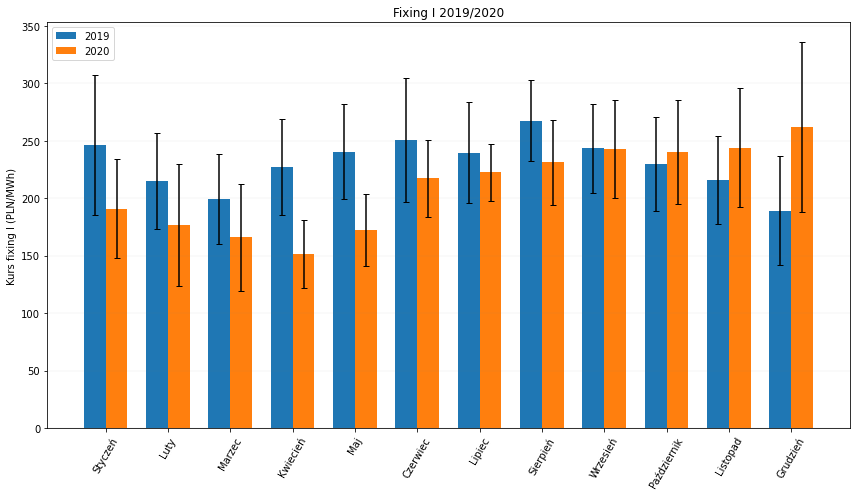

In [44]:
ind = np.arange(len(df_fx_monthly['fixing I course 2019_mean']))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(
figsize=(12,7))
rects1 = ax.bar(ind - width/2, df_fx_monthly['fixing I course 2019_mean'] , width, yerr=df_fx_monthly['fixing I course 2019_std'],
                label='2019', capsize=3)
rects2 = ax.bar(ind + width/2, df_fx_monthly['fixing I course 2020_mean'], width, yerr=df_fx_monthly['fixing I course 2020_std'],
                label='2020', capsize=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Kurs fixing I (PLN/MWh)')
ax.set_title('Fixing I 2019/2020')
ax.set_xticks(ind)
ax.set_xticklabels(df_fx_monthly['pl_month_name'], rotation=60)
ax.grid(color='grey', linestyle='-', linewidth=0.15, alpha=0.5, axis = 'y')
ax.legend()


fig.tight_layout()

plt.show()

### Ceny energii elektrycznej w poszczególnych dniach i godzinach

In [45]:
cats = ["Poniedziałek", "Wtorek", "Środa", "Czwartek", "Piątek", "Sobota", "Niedziela"]
df2020['pl_weekday'] = pd.Categorical(df2020['pl_weekday'], categories=cats, ordered=True)

In [46]:
#new_df = df2020.copy()

In [47]:
#new_df.rename(columns={"pl_weekday": "Dzień tygodnia"})

In [48]:
df

,date,fixing I course (PLN/MWh),month,month_name,hour,week,date_normalize,day_of_week,day_of_month,md,season,pl_weekday,pl_month_name,pl_season_name,quarter
0,2019-01-02 01:00:00,40.00,1.0,January,1.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
1,2019-01-02 02:00:00,31.00,1.0,January,2.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
2,2019-01-02 03:00:00,31.00,1.0,January,3.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
3,2019-01-02 04:00:00,31.00,1.0,January,4.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
4,2019-01-02 05:00:00,31.00,1.0,January,5.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17418,2020-12-27 19:00:00,198.81,12.0,December,19.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4
17419,2020-12-27 20:00:00,195.00,12.0,December,20.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4
17420,2020-12-27 21:00:00,186.03,12.0,December,21.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4
17421,2020-12-27 22:00:00,174.75,12.0,December,22.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4


In [49]:
cats = ["Poniedziałek", "Wtorek", "Środa", "Czwartek", "Piątek", "Sobota", "Niedziela"]
df['pl_weekday'] = pd.Categorical(df['pl_weekday'], categories=cats, ordered=True)

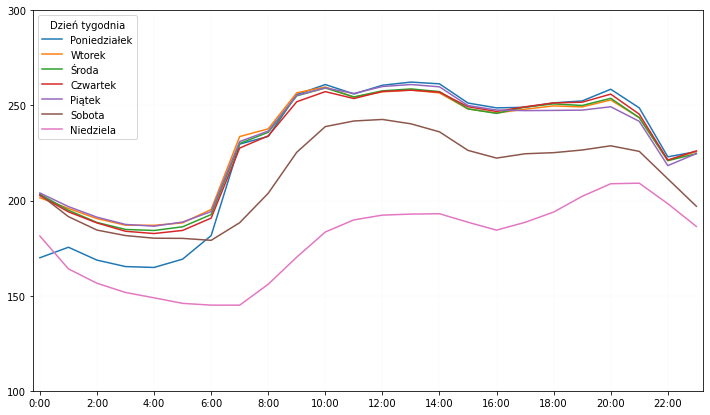

In [50]:
hourly_weekday_rent = df.pivot_table(index=df['date'].dt.hour, 
                     columns='pl_weekday', 
                     values='fixing I course (PLN/MWh)', 
                     aggfunc='mean')

#hourly_weekday_rent.plot(figsize=(12,7)).set(title = " Ceny energii w tygodniu", ylabel = 'Fixing I', xlabel=None)
hourly_weekday_rent.plot(figsize=(12,7)).set(ylabel = None, xlabel=None)

plt.grid(color='#dcdcdc', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
plt.legend(title="Dzień tygodnia")
plt.margins(0.01)
#plt.ylim(np.arange(0, 23, 2))
plt.yticks(np.arange(100, 350, 50))
x = np.arange(0, 23, 2)
labels = ['0:00', '2:00', '4:00', '6:00', '8:00', '10:00', '12:00', '14:00', '16:00', '18:00', '20:00', '22:00']
plt.xticks(x, labels)
#plt.savefig('wykres.eps', format='eps')
#plt.savefig('Rysunek8.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


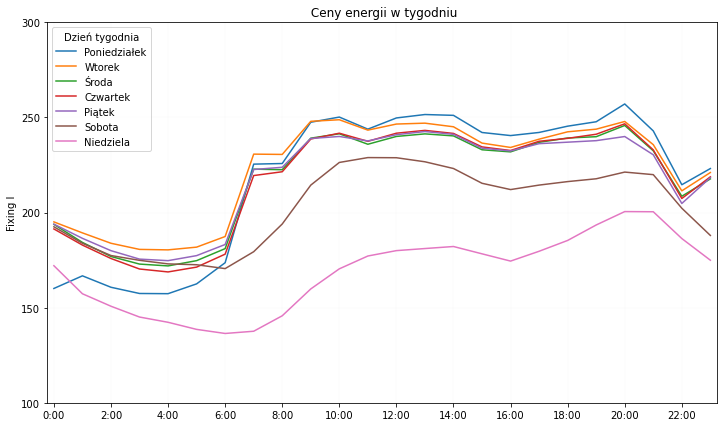

In [51]:
hourly_weekday_rent = df2020.pivot_table(index=df2020['date'].dt.hour, 
                     columns='pl_weekday', 
                     values='fixing I course (PLN/MWh)', 
                     aggfunc='mean')


hourly_weekday_rent.plot(figsize=(12,7)).set(title = " Ceny energii w tygodniu", ylabel = 'Fixing I', xlabel=None)
plt.grid(color='#dcdcdc', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
plt.legend(title="Dzień tygodnia")
plt.margins(0.01)
#plt.ylim(np.arange(0, 23, 2))
plt.yticks(np.arange(100, 350, 50))
x = np.arange(0, 23, 2)
labels = ['0:00', '2:00', '4:00', '6:00', '8:00', '10:00', '12:00', '14:00', '16:00', '18:00', '20:00', '22:00']
plt.xticks(x, labels)
#plt.savefig('wykres.eps', format='eps')
plt.savefig('Rysunek8.eps', format='eps')
plt.show()

### Zapotrzebowanie na energie

In [52]:
dataa = pd.read_csv('ZAP_KSE_20190101to20190601_20190604094302.csv', sep=';')

In [53]:
dataa['year'] = pd.to_datetime(dataa['Data'] ,errors = 'coerce',format = '%Y%m%d').dt.strftime("%Y")
dataa['month'] = pd.to_datetime(dataa['Data'] ,errors = 'coerce',format = '%Y%m%d').dt.strftime("%m")
dataa['day'] = pd.to_datetime(dataa['Data'] ,errors = 'coerce',format = '%Y%m%d').dt.strftime("%d")

In [54]:
rows_with_nan = [index for index, row in dataa.iterrows() if row.isnull().any()]

In [55]:
rows_with_nan

[]

In [56]:
dataa

,Data,Godz.,Dobowa prognoza zapotrzebowania KSE,Rzeczywiste zapotrzebowanie KSE,year,month,day
0,20190101,1,15000,"15011,513",2019,01,01
1,20190101,2,14400,"14466,588",2019,01,01
2,20190101,3,13900,"13773,575",2019,01,01
3,20190101,4,13400,"13406,2",2019,01,01
4,20190101,5,13200,"13216,3",2019,01,01
...,...,...,...,...,...,...,...
17536,20201231,19,20374,"19756,275",2020,12,31
17537,20201231,20,19251,"18846,863",2020,12,31
17538,20201231,21,17990,"17761,538",2020,12,31
17539,20201231,22,17099,"16865,325",2020,12,31


In [57]:
datas = pd.DataFrame({'year': dataa['year'],
                     'month': dataa['month'],
                     'day': dataa['day'],
                     'hour': dataa['Godz.']})
dataa['date'] = pd.to_datetime(datas)

In [58]:
dataa[22:32]

,Data,Godz.,Dobowa prognoza zapotrzebowania KSE,Rzeczywiste zapotrzebowanie KSE,year,month,day,date
22,20190101,23,15900,"15653,888",2019,01,01,2019-01-01 23:00:00
23,20190101,24,14900,"14593,1",2019,01,01,2019-01-02 00:00:00
24,20190102,1,13968,"13763,438",2019,01,02,2019-01-02 01:00:00
25,20190102,2,13646,"13467,763",2019,01,02,2019-01-02 02:00:00
26,20190102,3,13396,"13238,463",2019,01,02,2019-01-02 03:00:00
27,20190102,4,13393,"13326,788",2019,01,02,2019-01-02 04:00:00
28,20190102,5,13787,"13771,863",2019,01,02,2019-01-02 05:00:00
29,20190102,6,15005,"14916,875",2019,01,02,2019-01-02 06:00:00
30,20190102,7,17750,"18032,325",2019,01,02,2019-01-02 07:00:00
31,20190102,8,20299,"20340,475",2019,01,02,2019-01-02 08:00:00


In [59]:
dataa = dataa.drop(dataa.columns[[0,1,3,4,5,6]], axis = 1)
 

In [60]:
new_df = pd.merge(df, dataa, how='left', on=['date'])

In [61]:
rows_with_nan = [index for index, row in new_df.iterrows() if row.isnull().any()]
print(rows_with_nan)

[2134, 2135, 10870, 10871]


In [62]:
new_df = new_df.drop(2134)
new_df = new_df.drop(2135)
new_df = new_df.drop(10870)
new_df = new_df.drop(10871)

In [63]:
rows_with_nan = [index for index, row in new_df.iterrows() if row.isnull().any()]
print(rows_with_nan)

[]


In [64]:
new_df

,date,fixing I course (PLN/MWh),month,month_name,hour,week,date_normalize,day_of_week,day_of_month,md,season,pl_weekday,pl_month_name,pl_season_name,quarter,Dobowa prognoza zapotrzebowania KSE
0,2019-01-02 01:00:00,40.00,1.0,January,1.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1,13968.0
1,2019-01-02 02:00:00,31.00,1.0,January,2.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1,13646.0
2,2019-01-02 03:00:00,31.00,1.0,January,3.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1,13396.0
3,2019-01-02 04:00:00,31.00,1.0,January,4.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1,13393.0
4,2019-01-02 05:00:00,31.00,1.0,January,5.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1,13787.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17418,2020-12-27 19:00:00,198.81,12.0,December,19.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4,19000.0
17419,2020-12-27 20:00:00,195.00,12.0,December,20.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4,19000.0
17420,2020-12-27 21:00:00,186.03,12.0,December,21.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4,18500.0
17421,2020-12-27 22:00:00,174.75,12.0,December,22.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4,17600.0


In [65]:
#new_df.to_excel("full_data.xlsx") 

In [66]:
new_df

,date,fixing I course (PLN/MWh),month,month_name,hour,week,date_normalize,day_of_week,day_of_month,md,season,pl_weekday,pl_month_name,pl_season_name,quarter,Dobowa prognoza zapotrzebowania KSE
0,2019-01-02 01:00:00,40.00,1.0,January,1.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1,13968.0
1,2019-01-02 02:00:00,31.00,1.0,January,2.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1,13646.0
2,2019-01-02 03:00:00,31.00,1.0,January,3.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1,13396.0
3,2019-01-02 04:00:00,31.00,1.0,January,4.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1,13393.0
4,2019-01-02 05:00:00,31.00,1.0,January,5.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1,13787.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17418,2020-12-27 19:00:00,198.81,12.0,December,19.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4,19000.0
17419,2020-12-27 20:00:00,195.00,12.0,December,20.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4,19000.0
17420,2020-12-27 21:00:00,186.03,12.0,December,21.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4,18500.0
17421,2020-12-27 22:00:00,174.75,12.0,December,22.0,52.0,2020-12-27,6.0,27.0,12-27,Winter,Niedziela,Grudzień,Zima,4,17600.0


In [67]:
cc = new_df.drop(new_df.columns[[0,2,3,5,6,7, 8,9,10,11,12,13,14,15]], axis = 1)
 

In [68]:
#cc = cc.drop(cc.columns[[2,4,5,6,7]], axis = 1)

In [69]:
#cc = cc.dropna()`

In [70]:
rain_temp_cor = cc.corr() # table of correlation between variables
rain_temp_cor.style.background_gradient(cmap='coolwarm', axis=None)
rain_temp_cor.style.background_gradient(cmap='coolwarm').set_precision(2)

,fixing I course (PLN/MWh),hour
fixing I course (PLN/MWh),1.00,0.33
hour,0.33,1.00


In [71]:
new_df.to_excel("full_data.xlsx") 

In [72]:
listopad = new_df[new_df['pl_month_name'] =='Wrzesień']

In [73]:
listopad = listopad[listopad['date']>'2020-01-01 00:00:00'].reset_index(drop=True)


In [74]:
listopad_zap = listopad .groupby(['date_normalize']).agg({'Dobowa prognoza zapotrzebowania KSE':np.mean} )
listopad_zap = listopad_zap.reset_index() 

In [75]:
listopad_fixing = listopad .groupby(['date_normalize']).agg({'fixing I course (PLN/MWh)':np.mean} )
listopad_fixing = listopad_fixing.reset_index() 

In [76]:
# fig, ax = plt.subplots(figsize=(13,7))
# ax2 = ax.twinx()
# ax2.plot(listopad_fixing["date_normalize"], listopad_fixing["fixing I course (PLN/MWh)"], color=(190/255,190/255,190/255,0.7), label='Cena energii elektrycznej')
# ax.bar(listopad_zap["date_normalize"], listopad_zap["Dobowa prognoza zapotrzebowania KSE"], color='green', label='Zapotrzebowanie')
# ax.set_ylabel("Number of bike rentals", fontsize='14')
# ax2.set_ylabel("Average temperature [°C]", fontsize='14')
# ax.tick_params(axis='x', rotation=90)
# ax.legend(loc='upper left')
# ax2.legend(loc='upper right')
# plt.show()


### 3.1. Energy market analysis

In [77]:
#df2019

In [77]:
import statistics

In [78]:
smallest_hourly_fixing_price_2019 = min(df2019['fixing I course (PLN/MWh)'])
print('The lowest hourly electricity price in 2019 is: ', smallest_hourly_fixing_price_2019, "PLN/MWh")
biggest_hourly_fixing_price_2019 = max(df2019['fixing I course (PLN/MWh)'])
print('The largest hourly electricity price in 2019 is: ', biggest_hourly_fixing_price_2019, "PLN/MWh")
average_hourly_fixing_price_2019 = statistics.mean(df2019['fixing I course (PLN/MWh)'])
print('Average hourly electricity price in 2019 is: ', average_hourly_fixing_price_2019, "PLN/MWh")

The lowest hourly electricity price in 2019 is:  31.0 PLN/MWh
The largest hourly electricity price in 2019 is:  483.82 PLN/MWh
Average hourly electricity price in 2019 is:  230.33412296771237 PLN/MWh


In [79]:
smallest_hourly_fixing_price_2020 = min(df2020['fixing I course (PLN/MWh)'])
print('The lowest hourly electricity price in 2020 is: ', smallest_hourly_fixing_price_2020, "PLN/MWh")
biggest_hourly_fixing_price_2020 = max(df2020['fixing I course (PLN/MWh)'])
print('The largest hourly electricity price in 2020 is: ', biggest_hourly_fixing_price_2020, "PLN/MWh")
average_hourly_fixing_price_2020 = statistics.mean(df2020['fixing I course (PLN/MWh)'])
print('Average hourly electricity price in 2020 is: ', average_hourly_fixing_price_2020, "PLN/MWh")

The lowest hourly electricity price in 2020 is:  56.73 PLN/MWh
The largest hourly electricity price in 2020 is:  449.0 PLN/MWh
Average hourly electricity price in 2020 is:  209.3492091631173 PLN/MWh


### Typowy rozwój cenowy na RDN 

In [80]:
df2020['date'].astype(str).str[11:16]

0       00:00
1       01:00
2       02:00
3       03:00
4       04:00
        ...  
8682    19:00
8683    20:00
8684    21:00
8685    22:00
8686    23:00
Name: date, Length: 8687, dtype: object

In [81]:
df_fx_hourly = df2020.groupby(['hour']).agg({'fixing I course (PLN/MWh)':np.mean})
df_fx_hourly = df_fx_hourly.reset_index() 

In [82]:
df_fx_hourly

,hour,fixing I course (PLN/MWh)
0,0.0,185.584834
1,1.0,178.690746
2,2.0,172.263573
3,3.0,168.109171
4,4.0,166.917597
5,5.0,168.387265
6,6.0,172.866796
7,7.0,205.305055
8,8.0,209.004365
9,9.0,226.499972


In [83]:
df2020['date'].astype(str).str[11:16]

0       00:00
1       01:00
2       02:00
3       03:00
4       04:00
        ...  
8682    19:00
8683    20:00
8684    21:00
8685    22:00
8686    23:00
Name: date, Length: 8687, dtype: object

In [84]:
df_fx_hourly['h-m']=df2020['date'].astype(str).str[11:16]

In [85]:
df_fx_hourly['fixing I course (PLN/MWh)'][0] = df_fx_hourly['fixing I course (PLN/MWh)'][1]

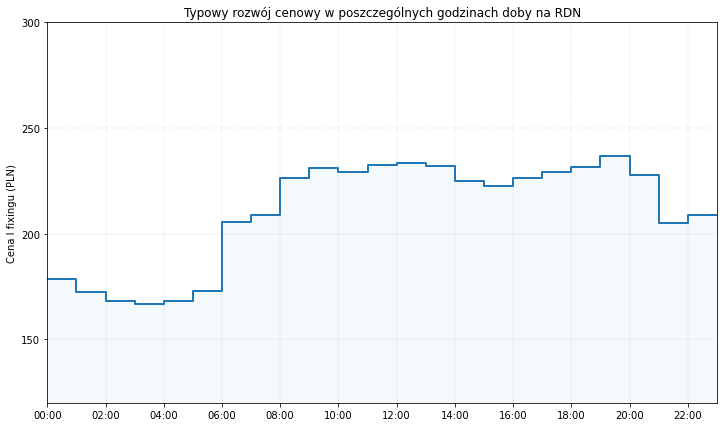

In [86]:
fig = plt.subplots(figsize=(12,7))

plt.step(df_fx_hourly['h-m'], df_fx_hourly['fixing I course (PLN/MWh)'],
        linewidth=2.0)
plt.fill_between(df_fx_hourly['h-m'],df_fx_hourly['fixing I course (PLN/MWh)'], step="pre", alpha=0.2, color='#cce7f1')
plt.title('Typowy rozwój cenowy w poszczególnych godzinach doby na RDN')
my_xticks = np.array(df_fx_hourly['h-m'])
frequency = 2
plt.xticks(my_xticks[::frequency], my_xticks[::frequency], rotation=0)
plt.ylabel("Cena I fixingu (PLN)")
plt.margins(0.)
plt.ylim(120,270, 30)
plt.yticks(np.arange(150, 350, 50))

plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.7, axis='both')
#plt.grid()



plt.show()


### Typical price development of electricity on the Day-Ahead Market in 2019-2020

In [87]:
df_fx_hourly = df.groupby(['hour']).agg({'fixing I course (PLN/MWh)':np.mean})
df_fx_hourly = df_fx_hourly.reset_index() 

In [88]:
df_fx_hourly

,hour,fixing I course (PLN/MWh)
0,0.0,195.124248
1,1.0,187.531157
2,2.0,181.237914
3,3.0,177.387534
4,4.0,176.334160
5,5.0,177.527961
6,6.0,182.639876
7,7.0,212.128953
8,8.0,219.614421
9,9.0,238.561074


In [89]:
df['date'].astype(str).str[11:16]

0        01:00
1        02:00
2        03:00
3        04:00
4        05:00
         ...  
17418    19:00
17419    20:00
17420    21:00
17421    22:00
17422    23:00
Name: date, Length: 17421, dtype: object

In [90]:
df_fx_hourly['h-m']=df2020['date'].astype(str).str[11:16]

In [91]:
df_fx_hourly['fixing I course (PLN/MWh)'][0] = df_fx_hourly['fixing I course (PLN/MWh)'][1]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


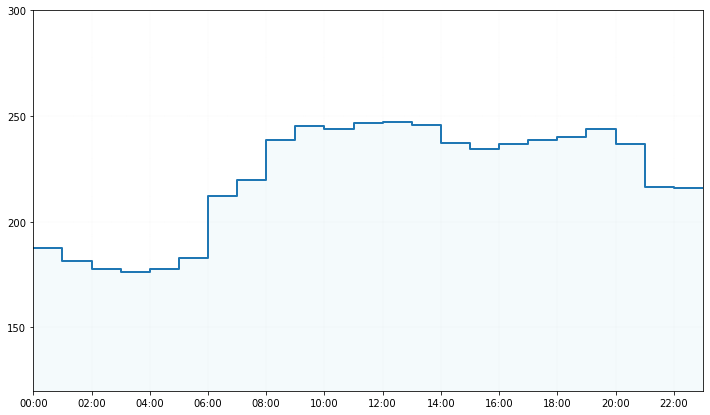

In [92]:
#cce7f1
#e9e9e9

fig = plt.subplots(figsize=(12,7))

plt.step(df_fx_hourly['h-m'], df_fx_hourly['fixing I course (PLN/MWh)'], ls='-',
        linewidth=2.0)
plt.fill_between(df_fx_hourly['h-m'],df_fx_hourly['fixing I course (PLN/MWh)'], step="pre", alpha=0.2, color='#cce7f1')
#plt.title('Typowy rozwój cenowy w poszczególnych godzinach doby na RDN')
my_xticks = np.array(df_fx_hourly['h-m'])
frequency = 2
plt.xticks(my_xticks[::frequency], my_xticks[::frequency], rotation=0)
#plt.ylabel("Cena I fixingu (PLN)")
plt.margins(0.)
plt.ylim(120,270, 30)
plt.yticks(np.arange(150, 350, 50))

plt.grid(color='#d2d2d2', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
#plt.grid()


plt.savefig('Rysunek7.eps', format='eps')
plt.show()


In [93]:
# df_fx_hourly.loc[df_fx_hourly['hour']==0, 'hour'] = 24
#df_fx_hourly = df_fx_hourly.sort_values(by=['hour'], na_position = 'first', ascending=True).reset_index(drop = True)

In [94]:
df2019_daily = df2019.groupby(['date_normalize']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index() 
df2019_daily['day_of_year'] = pd.to_datetime(df2019_daily['date_normalize']).dt.dayofyear

df2020_daily = df2020.groupby(['date_normalize']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index() 
df2020_daily['day_of_year'] = pd.to_datetime(df2020_daily['date_normalize']).dt.dayofyear

In [95]:
df2019_daily

,date_normalize,fixing I course (PLN/MWh),day_of_year
0,2019-01-02,162.571304,2
1,2019-01-03,223.377083,3
2,2019-01-04,242.027083,4
3,2019-01-05,219.932917,5
4,2019-01-06,213.270833,6
...,...,...,...
359,2019-12-27,183.994583,361
360,2019-12-28,175.540417,362
361,2019-12-29,168.481667,363
362,2019-12-30,132.883333,364


In [96]:
minmax_2019 = df2019.groupby(['date_normalize']).agg({'fixing I course (PLN/MWh)': ['min', 'max']}).reset_index()
minmax_2019['diff'] = minmax_2019['fixing I course (PLN/MWh)']['max'] - minmax_2019['fixing I course (PLN/MWh)']['min']

minmax_2020 = df2020.groupby(['date_normalize']).agg({'fixing I course (PLN/MWh)': ['min', 'max']}).reset_index()
minmax_2020['diff'] = minmax_2020['fixing I course (PLN/MWh)']['max'] - minmax_2020['fixing I course (PLN/MWh)']['min']

In [97]:
minmax_2019['diff'].describe()

count    364.000000
mean      93.608049
std       33.697546
min       31.580000
25%       71.065000
50%       89.770000
75%      110.250000
max      248.720000
Name: diff, dtype: float64

In [98]:
smallest_daily_spread_fixing_prices_2019 = min(minmax_2019['diff'])
print('The lowest daily spread of electricity prices in 2019 is: ', smallest_daily_spread_fixing_prices_2019, "PLN/MWh")

largest_daily_spread_fixing_prices_2019 = max(minmax_2019['diff'])
print('The largest daily spread of electricity prices in 2020 is: ', largest_daily_spread_fixing_prices_2019, "PLN/MWh")

average_daily_spread_fixing_prices_2020 = statistics.mean(minmax_2019['diff'])
print('Average hourly electricity price in 2020 is: ', average_daily_spread_fixing_prices_2020, "PLN/MWh")

The lowest daily spread of electricity prices in 2019 is:  31.580000000000013 PLN/MWh
The largest daily spread of electricity prices in 2020 is:  248.72 PLN/MWh
Average hourly electricity price in 2020 is:  93.60804945054946 PLN/MWh


In [99]:
smallest_daily_spread_fixing_prices_2020 = min(minmax_2020['diff'])
print('The lowest daily spread of electricity prices in 2019 is: ', smallest_daily_spread_fixing_prices_2020, "PLN/MWh")

largest_daily_spread_fixing_prices_2020 = max(minmax_2020['diff'])
print('The largest daily spread of electricity prices in 2020 is: ', largest_daily_spread_fixing_prices_2020, "PLN/MWh")

average_daily_spread_fixing_prices_2020 = statistics.mean(minmax_2020['diff'])
print('Average hourly electricity price in 2020 is: ', average_daily_spread_fixing_prices_2020, "PLN/MWh")

The lowest daily spread of electricity prices in 2019 is:  22.689999999999998 PLN/MWh
The largest daily spread of electricity prices in 2020 is:  249.27 PLN/MWh
Average hourly electricity price in 2020 is:  95.36803867403314 PLN/MWh


In [100]:
minmax_2020

date_normalize fixing I course (PLN/MWh)            diff
                                         min     max        
0       2020-01-01                    101.74  172.64   70.90
1       2020-01-02                    106.43  200.80   94.37
2       2020-01-03                    118.76  184.11   65.35
3       2020-01-04                     93.99  165.00   71.01
4       2020-01-05                    107.07  196.40   89.33
..             ...                       ...     ...     ...
357     2020-12-23                    153.11  356.16  203.05
358     2020-12-24                     70.95  214.45  143.50
359     2020-12-25                     92.33  248.70  156.37
360     2020-12-26                    110.00  212.91  102.91
361     2020-12-27                     68.00  198.81  130.81

[362 rows x 4 columns]

In [101]:
minmax_2020['diff'].describe()

count    362.000000
mean      95.368039
std       41.891195
min       22.690000
25%       60.542500
50%       89.990000
75%      118.470000
max      249.270000
Name: diff, dtype: float64

In [102]:
df2019_monthly = df2019.groupby(['month_name']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index()
df2020_monthly = df2020.groupby(['month_name']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index()

In [103]:
df2019_monthly

,month_name,fixing I course (PLN/MWh)
0,April,227.157708
1,August,267.395685
2,December,189.271398
3,February,214.887188
4,January,246.159666
5,July,239.451022
6,June,250.604653
7,March,199.216326
8,May,240.303602
9,November,215.854097


In [104]:
df2019_daily.describe()

,fixing I course (PLN/MWh),day_of_year
count,364.000000,364.000000
mean,230.317911,183.500000
std,36.339319,105.221988
min,118.285833,2.000000
25%,209.293750,92.750000
50%,232.432500,183.500000
75%,255.559687,274.250000
max,336.123333,365.000000


In [105]:
df2019_daily[0:89].describe()

,fixing I course (PLN/MWh),day_of_year
count,89.000000,89.000000
mean,219.910937,46.000000
std,36.621320,25.836021
min,140.143333,2.000000
25%,195.962917,24.000000
50%,218.675000,46.000000
75%,239.145417,68.000000
max,336.123333,90.000000


In [106]:
df2019_quarter = df2019.groupby(['quarter']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index() 
df2020_quarter = df2020.groupby(['quarter']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index() 

In [107]:
df2019[0:3100]

,date,fixing I course (PLN/MWh),month,month_name,hour,week,date_normalize,day_of_week,day_of_month,md,season,pl_weekday,pl_month_name,pl_season_name,quarter
0,2019-01-02 01:00:00,40.00,1.0,January,1.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
1,2019-01-02 02:00:00,31.00,1.0,January,2.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
2,2019-01-02 03:00:00,31.00,1.0,January,3.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
3,2019-01-02 04:00:00,31.00,1.0,January,4.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
4,2019-01-02 05:00:00,31.00,1.0,January,5.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3095,2019-05-11 01:00:00,200.15,5.0,May,1.0,19.0,2019-05-11,5.0,11.0,05-11,Spring,Sobota,Maj,Wiosna,2
3096,2019-05-11 02:00:00,200.15,5.0,May,2.0,19.0,2019-05-11,5.0,11.0,05-11,Spring,Sobota,Maj,Wiosna,2
3097,2019-05-11 03:00:00,200.15,5.0,May,3.0,19.0,2019-05-11,5.0,11.0,05-11,Spring,Sobota,Maj,Wiosna,2
3098,2019-05-11 04:00:00,200.15,5.0,May,4.0,19.0,2019-05-11,5.0,11.0,05-11,Spring,Sobota,Maj,Wiosna,2


In [108]:
df2019_ = df2019[0:8686]

In [109]:
df2020_ = df2020

In [111]:
cats = ["Styczeń", "Luty", "Marzec", "Kwiecień", "Maj", 
        "Czerwiec", "Lipiec", "Sierpień", "Wrzesień", "Październik", "Listopad", "Grudzień"]
df2019_weekly['pl_month_name'] = pd.Categorical(df2019_weekly['pl_month_name'], categories=cats, ordered=True)
df2019_weekly = df2019_weekly.sort_values(['pl_month_name', 'week'], ascending=[True, True] ).reset_index(drop=True)

df2020_weekly['pl_month_name'] = pd.Categorical(df2020_weekly['pl_month_name'], categories=cats, ordered=True)
df2020_weekly = df2020_weekly.sort_values(['pl_month_name', 'week'], ascending=[True, True] ).reset_index(drop=True)

In [112]:
df2019_weekly[0:10]

,week,pl_month_name,fixing I course (PLN/MWh)
0,1.0,Styczeń,212.653193
1,2.0,Styczeń,239.422798
2,3.0,Styczeń,230.937262
3,4.0,Styczeń,281.931310
4,5.0,Styczeń,263.522083
5,5.0,Luty,230.021528
6,6.0,Luty,216.284107
7,7.0,Luty,212.759286
8,8.0,Luty,211.260476
9,9.0,Luty,211.162396


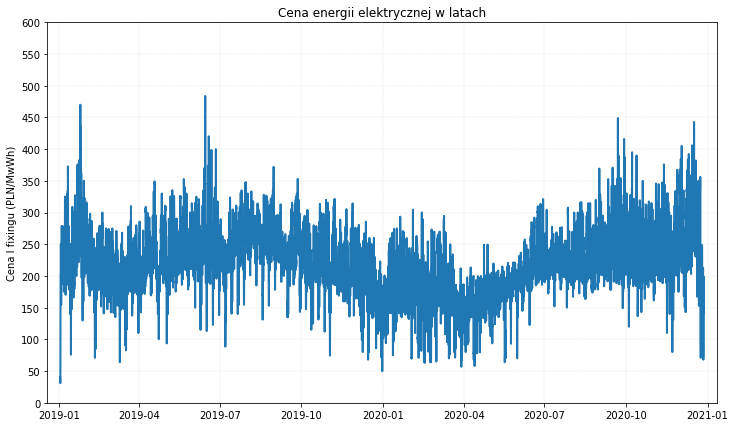